## Anas Majeed
## 21011519-019
## BS CS C - VI

# Leaf Disease Classification

# Motivation

![alt text](download-1.png)

* As farmers and agriculture field are the important part of our life , farmers are the root level building blocks in the economy of any country . They work really heard for a whole season to grow a specific crop for survival of his family

* Sometimes these crops on which he dedicated his whole 3-6 months to nurture these crops got disease as result of which they can't sell their crops on the price he was expecting

* And He thinks if he knew these if he knew the plant disease before hand , he can use spefic pesticides and fertilizers to get over these disease

* What if we can use deep learning techniques to help famers to know about specific disease , so that they can be ready before harvestifying their crops

![alt text](download.png)


# Description of Dataset

Here we announce the release of 4000 expertly curated images on healthy
and infected leaves of crops plants through the existing online platform PlantVillage. We describe
both the data and the platform. These data are the beginning of an ongoing, crowdsourcing effort
to enable computer vision approaches to help solve the problem of yield losses in crop plants due
to infectious diseases.

In [1]:
import os
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

## Extracting the Data and Converting in DataFrame

In [ ]:
dataset_path = '/kaggle/input/plantdisease/PlantVillage'
selected_classes = ['Pepper__bell___Bacterial_spot', 'Potato___Late_blight', 'Tomato_Late_blight']  

data = []
labels = []
# Iterate through the dataset directory
for class_name in os.listdir(dataset_path):
    if class_name in selected_classes:
        class_dir = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            data.append(img_path)
            labels.append(class_name)

df = pd.DataFrame({'data': data, 'label': labels})

### Viewing df

In [ ]:
df

,data,label
0,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
1,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
2,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
3,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
4,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
...,...,...
3901,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
3902,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
3903,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
3904,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight


# Analyzing the Data

In [ ]:
image = Image.open("/kaggle/input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG")
width, height = image.size
print(f"Width: {width}, Height: {height}")

Width: 256, Height: 256


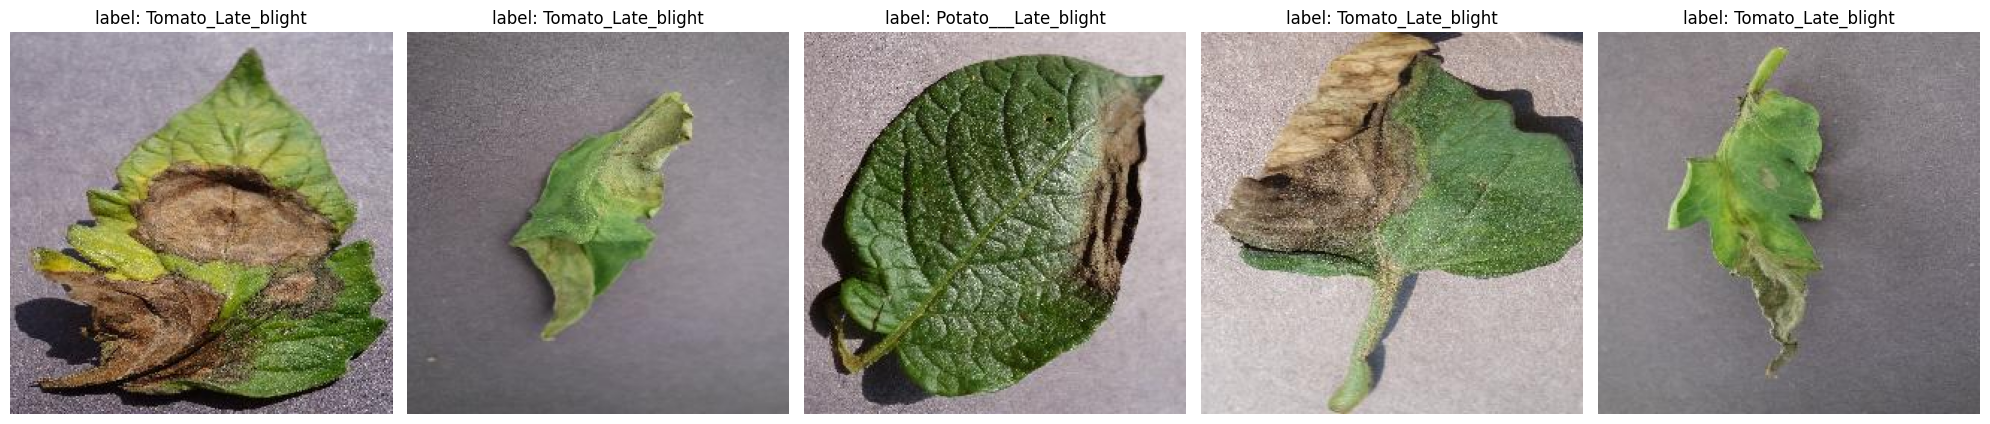

In [ ]:
plt.figure(figsize=(20, 15))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    index = np.random.choice(df.index)
    filename = df.loc[index, 'data']
    category = df.loc[index, 'label']
    img = Image.open(filename)
    plt.imshow(img)
    plt.title(f'label: {category}')
    plt.axis('off') 

plt.tight_layout()
plt.show()

## Extracting HOG Features and Preparing Data

In [ ]:
def extract_hog_features(image):
    # Convert the image to grayscale using cv2
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    hog = cv2.HOGDescriptor()
    
    # Compute HOG features
    hog_features = hog.compute(gray_image)

    return hog_features.flatten()

## Resizing the Data

In [ ]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
batch_size = 32  # Adjust batch size based on memory constraints
features_list = []
labels_list = []

# Resize function to downsample images
def resize_image(image, new_size=(128, 128)):
    return cv2.resize(image, new_size)

for start in range(0, len(df_shuffled), batch_size):
    end = min(start + batch_size, len(df_shuffled))
    batch = df_shuffled[start:end]

    batch_features = []
    batch_labels = []

    for index, row in batch.iterrows():
        image = cv2.imread(row['data'])
        resized_image = resize_image(image)  # Resize image to smaller dimensions
        hog_features = extract_hog_features(resized_image)
        batch_features.append(hog_features)
        batch_labels.append(row['label'])

    features_list.extend(batch_features)
    labels_list.extend(batch_labels)

Shape of extracted HOG features: (3906, 34020)


In [ ]:
# Convert lists to NumPy arrays
features_array = np.array(features_list)
labels_array = np.array(labels_list)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_array)

print("Shape of extracted HOG features:", features_scaled.shape)

Shape of extracted HOG features: (3906, 34020)


In [ ]:
len(labels_encoded)

3906

In [ ]:
np.unique(labels_encoded)

array([0, 1, 2])

# Test/Train Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_encoded, test_size=0.25, random_state=42 , stratify = labels_encoded)

In [ ]:
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)
print(type(X_test), X_test.shape)
print(type(y_test), y_test.shape)

<class 'numpy.ndarray'> (2929, 34020)
<class 'numpy.ndarray'> (2929,)
<class 'numpy.ndarray'> (977, 34020)
<class 'numpy.ndarray'> (977,)


# SVM

In [ ]:
lr_pipeline = Pipeline([
    ('pca', PCA(n_components=2100,random_state=42)), 
    ('classifier', LogisticRegression(max_iter = 1000,random_state=42))
])

lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=2100, random_state=42)),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

## Metrics

In [ ]:
predictions = lr_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8802


In [ ]:
report = classification_report(y_test, predictions, output_dict=True,zero_division=1)

# Convert the report to a pandas DataFrame for better visualization
report = pd.DataFrame(report).transpose()

print(report)

              precision    recall  f1-score     support
0              0.902542  0.855422  0.878351  249.000000
1              0.853175  0.860000  0.856574  250.000000
2              0.883436  0.903766  0.893485  478.000000
accuracy       0.880246  0.880246  0.880246    0.880246
macro avg      0.879718  0.873062  0.876136  977.000000
weighted avg   0.880562  0.880246  0.880183  977.000000


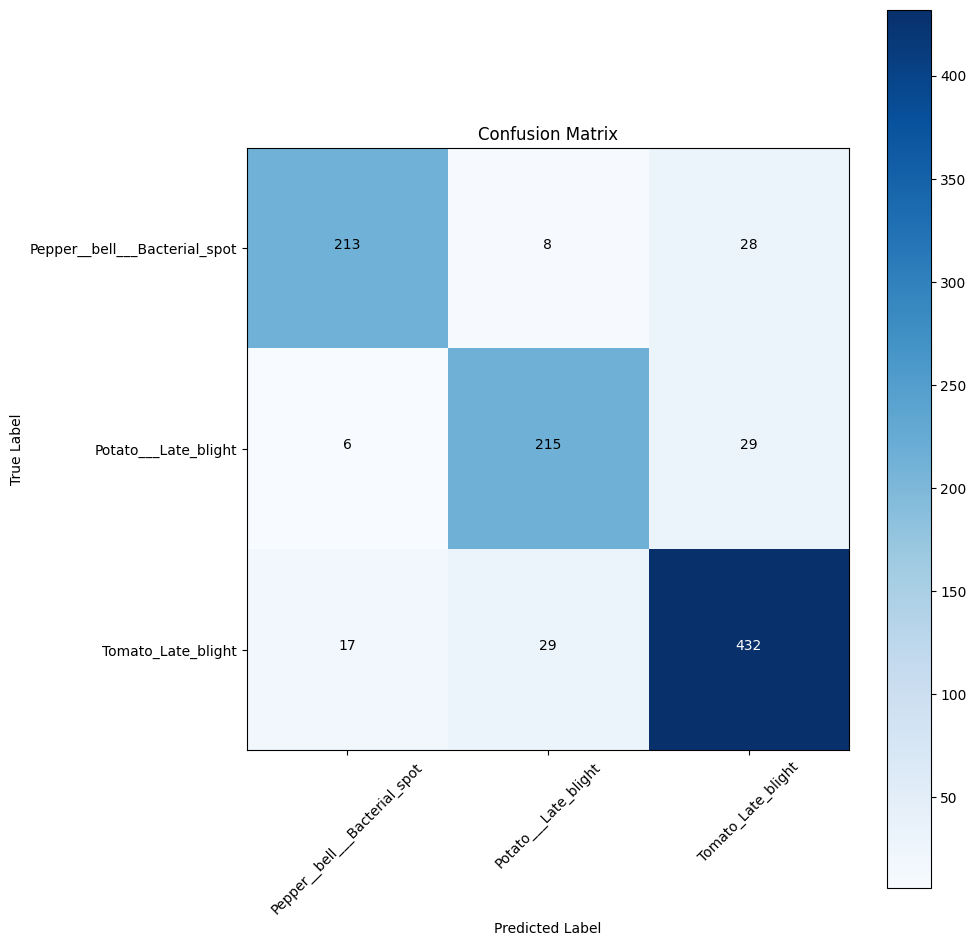

In [ ]:
classes = selected_classes


cm = confusion_matrix(y_test, predictions)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


plt.show()

# KNN

In [ ]:
knn_pipeline = Pipeline([
    ('pca', PCA(n_components=2100, random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=2100, random_state=42)),
                ('classifier', KNeighborsClassifier())])

In [ ]:
knn_predictions = knn_pipeline.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print(f"KNN Accuracy: {knn_accuracy:.4f}")

knn_report = classification_report(y_test, knn_predictions, output_dict=True, zero_division=1)
knn_report_df = pd.DataFrame(knn_report).transpose()
print(knn_report_df)

KNN Accuracy: 0.7083
              precision    recall  f1-score     support
0              0.947368  0.650602  0.771429  249.000000
1              0.477137  0.960000  0.637450  250.000000
2              0.957096  0.606695  0.742638  478.000000
accuracy       0.708291  0.708291  0.708291    0.708291
macro avg      0.793867  0.739099  0.717172  977.000000
weighted avg   0.831802  0.708291  0.723059  977.000000


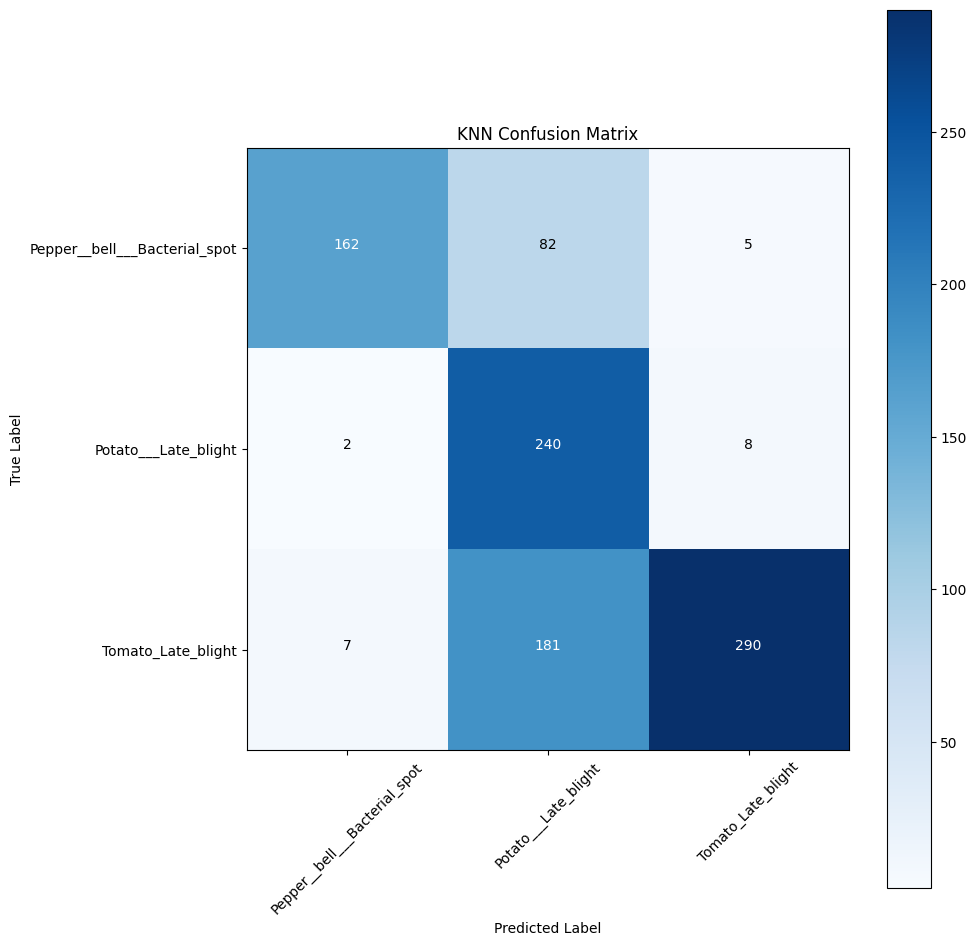

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

classes = label_encoder.classes_

# Confusion Matrix for KNN
knn_cm = confusion_matrix(y_test, knn_predictions)
plot_confusion_matrix(knn_cm, classes, title='KNN Confusion Matrix')


# Decision Tree

In [ ]:
# Decision Tree Classifier
dt_pipeline = Pipeline([
    ('pca', PCA(n_components=2100, random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=2100, random_state=42)),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [ ]:
dt_predictions = dt_pipeline.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")

dt_report = classification_report(y_test, dt_predictions, output_dict=True, zero_division=1)
dt_report_df = pd.DataFrame(dt_report).transpose()
print(dt_report_df)

Decision Tree Accuracy: 0.6264
              precision    recall  f1-score     support
0              0.600806  0.598394  0.599598  249.000000
1              0.508772  0.580000  0.542056  250.000000
2              0.716216  0.665272  0.689805  478.000000
accuracy       0.626407  0.626407  0.626407    0.626407
macro avg      0.608598  0.614555  0.610486  977.000000
weighted avg   0.633721  0.626407  0.629008  977.000000


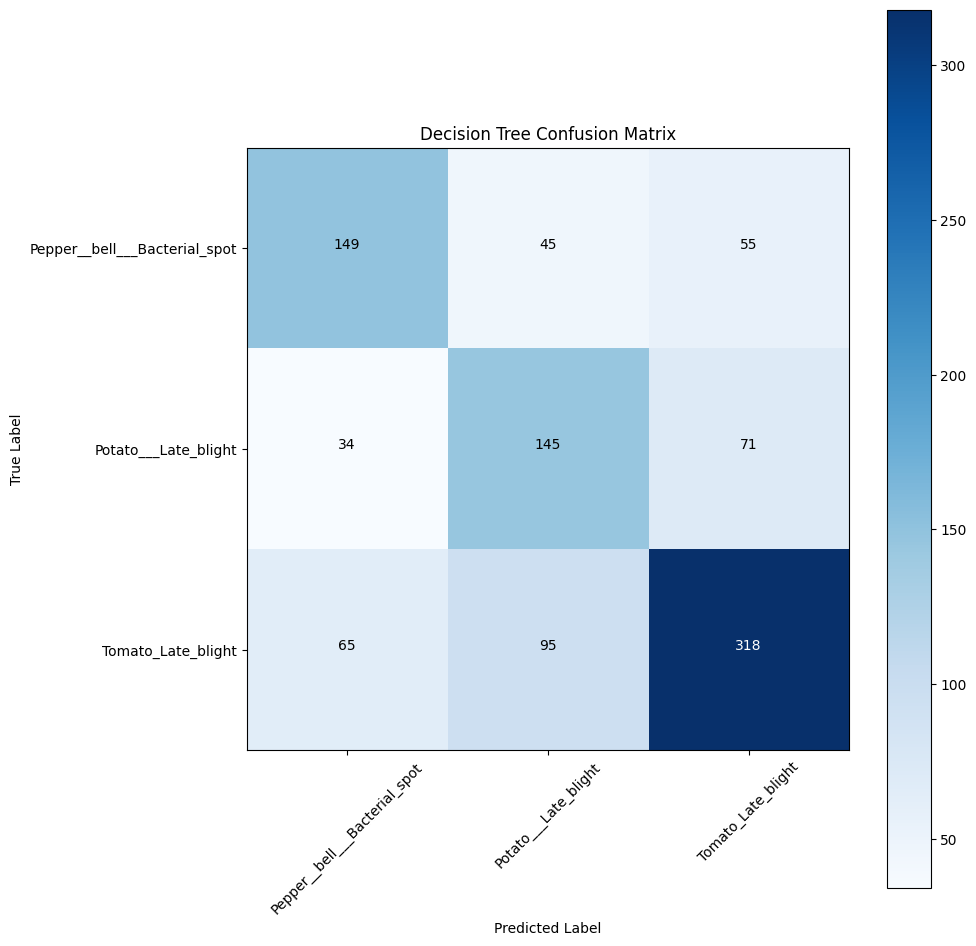

In [ ]:
# Confusion Matrix for Decision Tree
dt_cm = confusion_matrix(y_test, dt_predictions)
plot_confusion_matrix(dt_cm, classes, title='Decision Tree Confusion Matrix')

# CNN

In [2]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/kaggle/input/plantdisease/PlantVillage'
width=256
height=256
depth=3

Function to convert images to array

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Potato___healthy ...
[INFO] Image loading completed


Get Size of Processed Image

In [5]:
image_size = len(image_list)

Transform Image Labels uisng Scikit LabelBinarizer

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

Print the classes

In [7]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [8]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [9]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [10]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [11]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Model Summary

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)        0         
__________

In [13]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [14]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
73/73 [==============================] - 43s 583ms/step - loss: 0.2012 - acc: 0.9365 - val_loss: 0.5047 - val_acc: 0.9022
Epoch 2/25
73/73 [==============================] - 35s 479ms/step - loss: 0.1920 - acc: 0.9378 - val_loss: 0.8381 - val_acc: 0.8955
Epoch 3/25
73/73 [==============================] - 36s 491ms/step - loss: 0.1617 - acc: 0.9469 - val_loss: 0.9227 - val_acc: 0.8950
Epoch 4/25
73/73 [==============================] - 36s 490ms/step - loss: 0.1249 - acc: 0.9569 - val_loss: 0.9686 - val_acc: 0.8845
Epoch 5/25
73/73 [==============================] - 34s 470ms/step - loss: 0.1052 - acc: 0.9611 - val_loss: 0.2461 - val_acc: 0.9453
Epoch 6/25
73/73 [==============================] - 36s 487ms/step - loss: 0.0884 - acc: 0.9680 - val_loss: 0.1789 - val_acc: 0.9500
Epoch 7/25
73/73 [==============================] - 34s 468ms/step - loss: 0.0798 - acc: 0.9707 - val_loss: 0.1902 - val_acc: 0.9558
Epoch 8/25
73/73 [==============================] - 35s 483ms/step - 

Plot the train and val curve

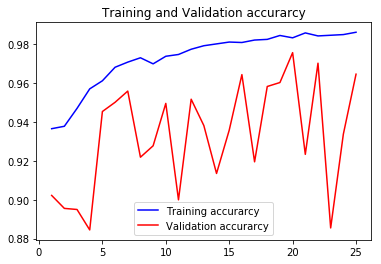

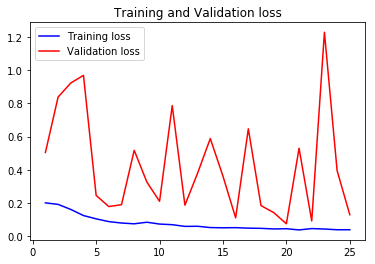

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Model Accuracy

In [16]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
591/591 [==============================] - 1s 2ms/step
Test Accuracy: 96.44670223221561


Save model using Pickle

In [17]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...
